In [20]:
#!mamba env create -f '../../environment.yml'
!mamba env update -f '../../environment.yml' --prune

[+] 0.0s
pkgs/main/noarch                                              No change
pkgs/r/noarch                                                 No change
pkgs/r/linux-64                                               No change
[+] 0.1s
conda-forge/linux-64 ━━╸━━━━━━━━━━━━━━━╸━━━━  15.0 B /  ??.?MB @ 287.0 B/s  0.1s
conda-forge/noarch   ━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/main/linux-64   ━━━━━━━━━━━━━╸━━━━━━━━━  16.4kB /  ??.?MB @ 320.7kB/s  0.1s[+] 0.2s
conda-forge/linux-64 ━━━━━╸━━━━━━━━━━━━━━━╸━ 823.7kB /  ??.?MB @   5.4MB/s  0.2s
conda-forge/noarch   ━━━━━━━━━━━╸━━━━━━━━━━━ 809.1kB /  ??.?MB @   5.3MB/s  0.2s
pkgs/main/linux-64   ━━━━━━━━━━━━━━━╸━━━━━━━ 426.0kB /  ??.?MB @   2.8MB/s  0.2s[+] 0.3s
conda-forge/linux-64 ━━━━━━━╸━━━━━━━━━━━━━━━   1.6MB /  ??.?MB @   6.2MB/s  0.3s
conda-forge/noarch   ━━━━━━━╸━━━━━━━━━━━━━━━   1.7MB /  ??.?MB @   6.6MB/s  0.3s
pkgs/main/linux-64   ━╸━━━━━━━━━━━━━━━╸━━━━━ 913.4kB /  ??.?MB @   3.6MB/s  0.3s[+] 0.4s
conda-forge/l

# Testing examples from remote_sensing 

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import shapely
import dask
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime
import pandas as pd

In [23]:
bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/mt_rainier.geojson')
#bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/olympic_peninsula.geojson')

## Forest cover fraction

In [24]:
%%time
forest_cover_fraction = easysnowdata.remote_sensing.get_forest_cover_fraction(bbox_gdf)
forest_cover_fraction

CPU times: user 19 ms, sys: 9.7 ms, total: 28.7 ms
Wall time: 28.2 ms


<xarray.DataArray (y: 158, x: 232)> Size: 147kB
dask.array<getitem, shape=(158, 232), dtype=float32, chunksize=(158, 232), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 1kB 46.95 46.95 46.95 46.95 ... 46.8 46.79 46.79
    spatial_ref  int64 8B 0
Attributes: (12/31)
    archive_facility:       VITO NV
    AREA_OR_POINT:          Area
    copyright:              Copernicus Service information 2020
    creator:                Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:  WGS84 (EPSG:4326)
    doi:                    10.5281/zenodo.3939050
    ...                     ...
    time_reference_year:    2019
    title:                  Dynamic Land Cover Map 100m 2019-nrt
    band_crs:               WGS84 (EPSG:4326)
    short_name:             Tree-CoverFraction-layer
    unit:                   %
    valid_range:            0, 100

Text(0.5, 1.0, 'Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

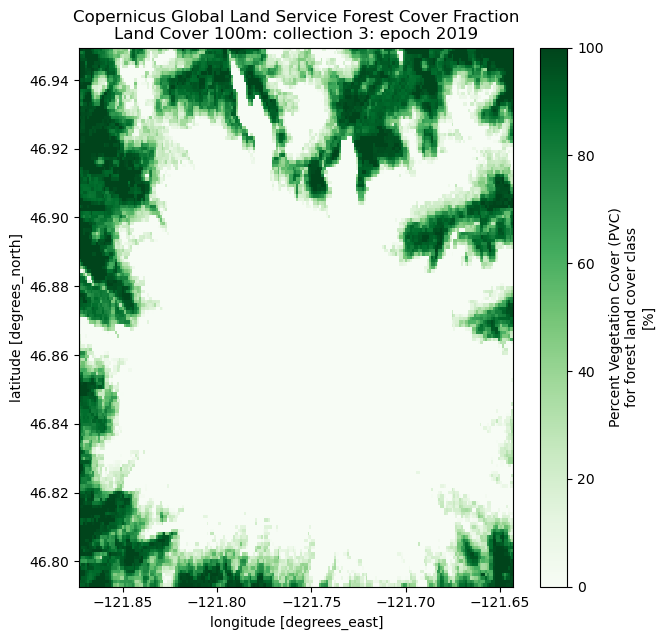

In [25]:
f,ax=plt.subplots(figsize=(7,7))

forest_cover_fraction.plot(ax=ax,cmap='Greens')

ax.set_title('Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

## Seasonal snow classification (Sturm & Liston 2021)

In [26]:
%%time
snow_classification = easysnowdata.remote_sensing.get_seasonal_snow_classification(bbox_gdf)
snow_classification

CPU times: user 7.32 ms, sys: 9.2 ms, total: 16.5 ms
Wall time: 16.2 ms


<xarray.DataArray (y: 57, x: 84)> Size: 19kB
dask.array<getitem, shape=(57, 84), dtype=float32, chunksize=(30, 84), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 672B -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 456B 46.95 46.95 46.94 46.94 ... 46.8 46.8 46.79
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         Band 1
    long_name:      Band 1
    class_info:     {1: {'name': 'Tundra', 'color': '#a100c8'}, 2: {'name': '...

Text(0.5, 1.0, 'Seasonal Snow Classification\nfrom Sturm & Liston 2021')

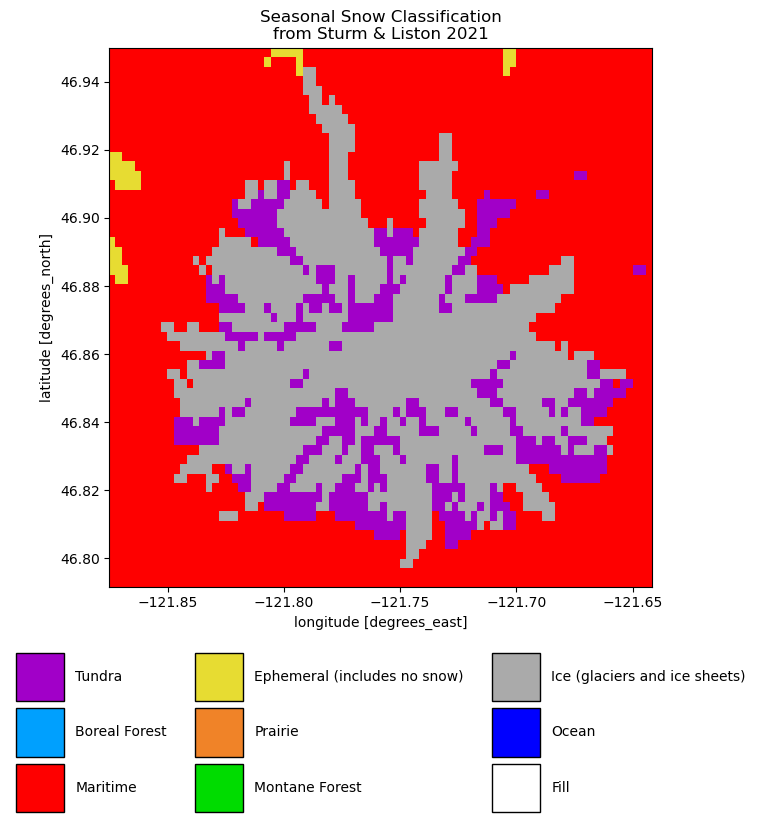

In [27]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in snow_classification.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in snow_classification.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(snow_classification.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
snow_classification.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Seasonal Snow Classification\nfrom Sturm & Liston 2021')

## ESA WorldCover

In [28]:
%%time
esa_worldcover = easysnowdata.remote_sensing.get_esa_worldcover(bbox_gdf)
esa_worldcover

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 1.25 s


<xarray.DataArray 'map' (latitude: 1874, longitude: 2757)> Size: 5MB
dask.array<getitem, shape=(1874, 2757), dtype=uint8, chunksize=(1874, 2757), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 15kB 46.95 46.95 46.95 ... 46.79 46.79 46.79
  * longitude    (longitude) float64 22kB -121.9 -121.9 -121.9 ... -121.6 -121.6
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-01-01
Attributes:
    nodata:      0
    class_info:  {10: {'name': 'Tree cover', 'color': '#006400'}, 20: {'name'...

Text(0.5, 1.0, 'ESA WorldCover\n2021 v200')

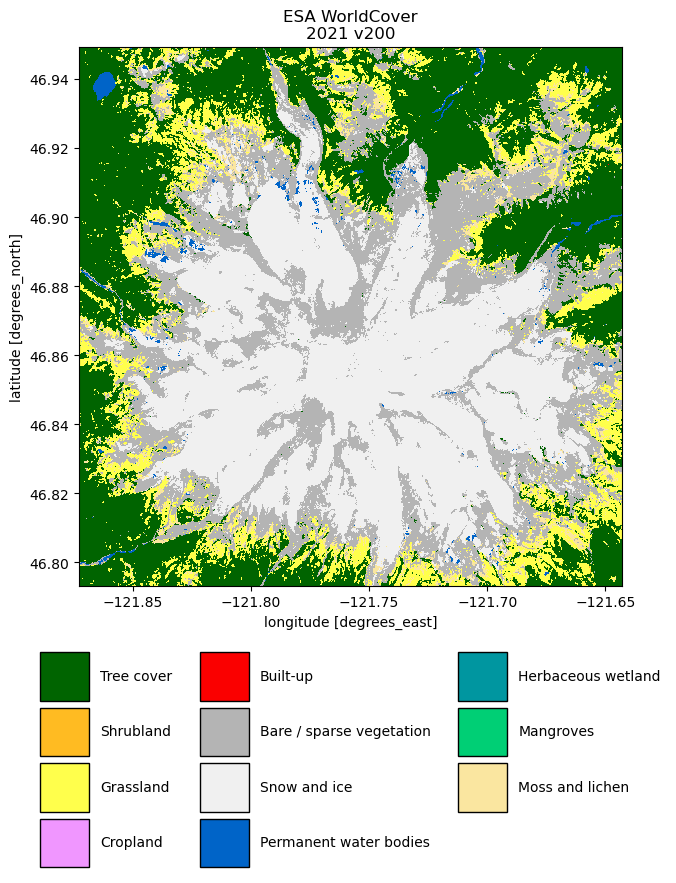

In [29]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in esa_worldcover.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in esa_worldcover.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(esa_worldcover.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
esa_worldcover.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('ESA WorldCover\n2021 v200')

## Sentinel-2

In [30]:
s2 = easysnowdata.remote_sensing.Sentinel2(bbox_input=bbox_gdf, start_date='2022-01-01', end_date='2022-01-31', catalog_choice='planetarycomputer')

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.


In [31]:
s2.get_rgb()

RGB data retrieved. Access with the .rgb attribute.


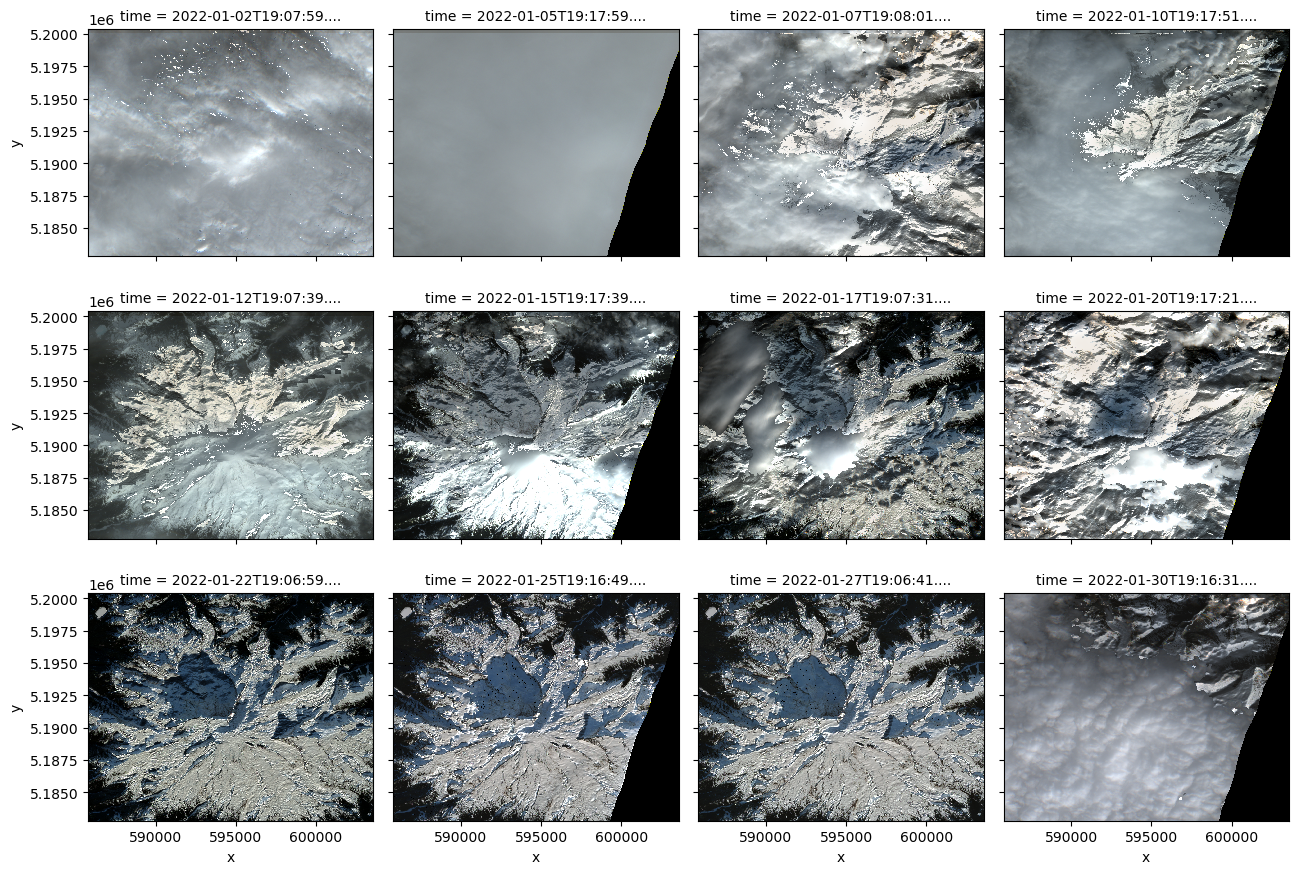

In [32]:
s2.rgb.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4, robust=True)

In [33]:
scl_da = s2.data.scl.isel(time=10)

Text(0.5, 1.0, 'Sentinel-2 SCL')

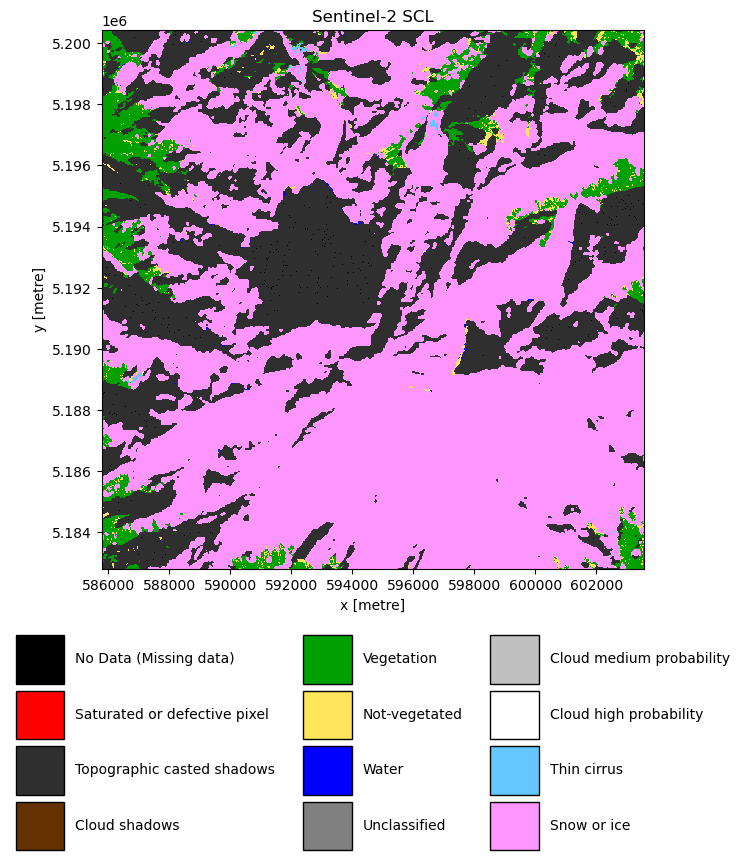

In [34]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in scl_da.attrs['scl_class_info'].values()]
class_colors = [class_info['color'] for class_info in scl_da.attrs['scl_class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(scl_da.attrs['scl_class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
scl_da.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/4,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Sentinel-2 SCL')

In [16]:
s2.mask_data()

Removed pixels with the following scene classification values:
No Data (Missing data)
Saturated or defective pixel
Topographic casted shadows
Cloud shadows
Cloud medium probability
Cloud high probability
Thin cirrus


In [ ]:
s2.get_ndsi()

In [ ]:
s2.ndsi.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4)

In [ ]:
s2.get_ndvi()

In [ ]:
s2.ndvi.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4)

## Sentinel-1

In [35]:
#!gdalinfo "https://zenodo.org/record/3939050/files/PROBAV_LC100_global_v3.0.1_2019-nrt_Tree-CoverFraction-layer_EPSG-4326.tif"
#!gdalinfo 'https://snowmelt.blob.core.windows.net/snowmelt/eric/snow_classification/SnowClass_GL_300m_10.0arcsec_2021_v01.0.tif'

In [45]:
s1 = easysnowdata.remote_sensing.Sentinel1(bbox_input=bbox_gdf, start_date='2020-01-01', end_date='2020-01-31')

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.
Border noise removed from the data.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [46]:
s1.data

<xarray.Dataset> Size: 251MB
Dimensions:             (y: 1763, x: 1779, time: 10)
Coordinates:
  * y                   (y) float64 14kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x                   (x) float64 14kB 5.858e+05 5.858e+05 ... 6.036e+05
    spatial_ref         int32 4B 32610
  * time                (time) datetime64[ns] 80B 2020-01-02T14:21:21.512761 ...
    sat:orbit_state     (time) object 80B 'descending' ... 'ascending'
    sat:relative_orbit  (time) int16 20B 13 64 115 137 13 64 115 137 13 64
Data variables:
    vh                  (time, y, x) float32 125MB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    vv                  (time, y, x) float32 125MB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
Attributes:
    units:    dB

<Axes: >

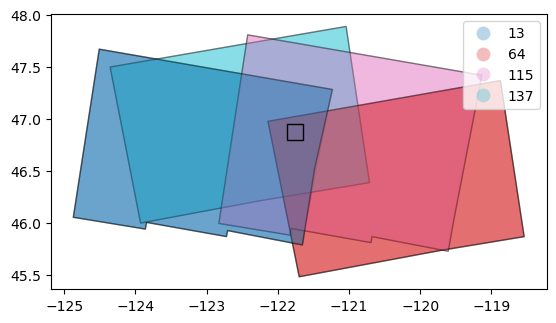

In [47]:
f,ax=plt.subplots()

s1.metadata.plot('sat:relative_orbit', ax=ax,edgecolor='black', categorical=True, legend=True, alpha=0.3)
bbox_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

In [ ]:
# import earthaccess
# earthaccess.login()

# results = earthaccess.search_data(
#     short_name='MOD10A1F',
#     cloud_hosted=True,
#     bounding_box=tuple(bbox_gdf.total_bounds),
#     temporal=('2022-01-01', '2022-01-05'),
# )

# #    temporal=(f"{time}",f"{time}")
# files=earthaccess.open(results)

# files

# ds = xr.open_mfdataset(files,chunks={})




#         temp_download_fp = '/tmp/local_folder'

#         files = earthaccess.download(results, temp_download_fp)

#         modis = rxr.open_rasterio(*files,mask_and_scale=True).squeeze()


#         modis_ndsi = modis['CGF_NDSI_Snow_Cover'].where(modis['CGF_NDSI_Snow_Cover']<=100,np.nan)
        
#         modis_ndsi_dict[rel_orbit] = modis_ndsi.rio.reproject_match(dataset)

#         shutil.rmtree(temp_download_fp)

In [ ]:
#ONLY LANDSAT AVAILABLE
# 
# # !pip install --upgrade xee

# import ee
# import xarray as xr

# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
# ds = xr.open_dataset('ee://NASA/HLS/HLSL30/v002', engine='ee')


In [83]:
# !CPL_VSIL_CURL_USE_HEAD=FALSE
# !GDAL_DISABLE_READDIR_ON_OPEN=YES
# !GDAL_HTTP_COOKIEJAR=/tmp/cookies.txt
# !GDAL_HTTP_COOKIEFILE=/tmp/cookies.txt


In [96]:
import rasterio as rio
import os
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  CPL_VSIL_CURL_USE_HEAD='FALSE',
                  GDAL_HTTP_NETRC='TRUE',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

In [ ]:
#!pip install GDAL

In [63]:
from osgeo import gdal

In [76]:
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR') #gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES') EMPTY_DIR
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_NETRC','True')

In [69]:
catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


In [71]:
band_info = {
    "coastal aerosol": {"landsat_band": "B01", "sentinel_band": "B01", "description": "430-450 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "blue": {"landsat_band": "B02", "sentinel_band": "B02", "description": "450-510 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "green": {"landsat_band": "B03", "sentinel_band": "B03", "description": "530-590 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "red": {"landsat_band": "B04", "sentinel_band": "B04", "description": "640-670 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "red-edge 1": {"landsat_band": "-", "sentinel_band": "B05", "description": "690-710 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "red-edge 2": {"landsat_band": "-", "sentinel_band": "B06", "description": "730-750 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "red-edge 3": {"landsat_band": "-", "sentinel_band": "B07", "description": "770-790 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "nir broad": {"landsat_band": "-", "sentinel_band": "B08", "description": "780-880 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "nir narrow": {"landsat_band": "B05", "sentinel_band": "B8A", "description": "850-880 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "swir 1": {"landsat_band": "B06", "sentinel_band": "B11", "description": "1570-1650 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "swir 2": {"landsat_band": "B07", "sentinel_band": "B12", "description": "2110-2290 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "water vapor": {"landsat_band": "-", "sentinel_band": "B09", "description": "930-950 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "cirrus": {"landsat_band": "B09", "sentinel_band": "B10", "description": "1360-1380 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "thermal infrared 1": {"landsat_band": "B10", "sentinel_band": "-", "description": "10600-11190 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "thermal": {"landsat_band": "B11", "sentinel_band": "-", "description": "11500-12510 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
    "Fmask": {"landsat_band": "Fmask", "sentinel_band": "Fmask", "description": "quality bits", "data_type": "uint8", "nodata": "255", "scale": "1"},
    "SZA": {"landsat_band": "SZA", "sentinel_band": "SZA", "description": "Sun zenith degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
    "SAA": {"landsat_band": "SAA", "sentinel_band": "SAA", "description": "Sun azimuth degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
    "VZA": {"landsat_band": "VZA", "sentinel_band": "VZA", "description": "View zenith degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
    "VAA": {"landsat_band": "VAA", "sentinel_band": "VAA", "description": "View azimuth degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
}

In [72]:
HLS_landsat_stac_items = catalog.search(collections=["HLSL30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=('2022-01-01','2022-02-01')).item_collection()
HLS_landsat_bands = [band for band, info in band_info.items() if info['landsat_band'] != '-']
HLS_landsat_stac_cfg = easysnowdata.utils.get_stac_cfg(sensor="HLSL30.v2.0")

L30_ds = odc.stac.load(
    HLS_landsat_stac_items,
    crs="utm",
    resolution=30,
    bands=HLS_landsat_bands,
    groupby="solar_day",
    chunks={'time':1,'x':512,'y':512},
    bbox=bbox_gdf.total_bounds,
    stac_cfg=HLS_landsat_stac_cfg,
)

#L30_ds = L30_ds.assign_coords({'platform': ('time',['Landsat-8' for _ in range(len(L30_ds.time) ) ] )})

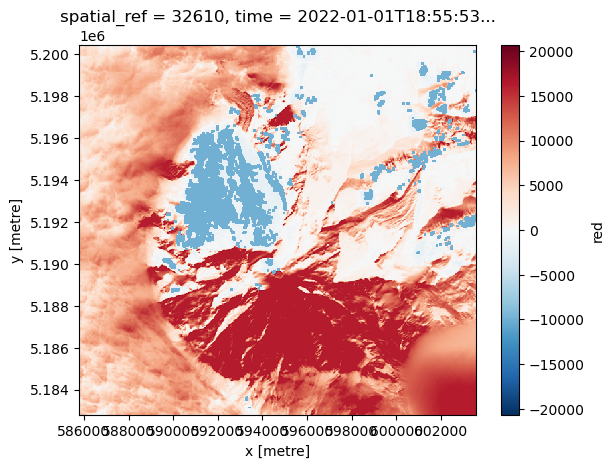

In [77]:
L30_ds['red'].isel(time=0).plot()

In [ ]:
one.assets['B04'].href

In [ ]:
!gdalinfo https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10TFT.2022001T185553.v2.0/HLS.L30.T10TFT.2022001T185553.v2.0.jpg

In [ ]:
from skimage import io

In [ ]:
plt.imshow(io.imread(one.assets['browse'].href))

In [ ]:
one = HLS_landsat_stac_items[2]
rxr.open_rasterio(one.assets['browse'].href).squeeze()

In [ ]:
HLS_landsat_stac_items.to_dict()

In [ ]:
#HLS_landsat_stac_items[0]
test = gpd.GeoDataFrame.from_features(HLS_landsat_stac_items.to_dict(),'EPSG:4326')

In [ ]:
test.plot()

In [ ]:
[band for band, info in band_info.items() if info['sentinel_band'] != '-']

In [ ]:
HLS_sentinel_stac_items = catalog.search(collections=["HLSS30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=('2022-01-01','2022-02-01')).item_collection()
HLS_sentinel_bands = [band for band, info in band_info.items() if info['sentinel_band'] != '-']
HLS_sentinel_stac_cfg = easysnowdata.utils.get_stac_cfg(sensor="HLSS30.v2.0")

S30_ds = odc.stac.load(
    HLS_sentinel_stac_items,
    crs="utm",
    resolution=30,
    bands=HLS_sentinel_bands,
    groupby="solar_day",
    chunks={'time':1,'x':512,'y':512},
    bbox=bbox_gdf.total_bounds,
    stac_cfg=HLS_sentinel_stac_cfg,
)

In [ ]:
S30_ds

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def HLS_xml_url_to_metadata_df(url):
    # URL of the XML file

    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the XML content of the response with BeautifulSoup
    soup = BeautifulSoup(response.content, 'lxml-xml')  # 'lxml-xml' parser is used for parsing XML

    # Create a dictionary to hold the data
    data = {}

    # Iterate over all tags in the soup object
    for tag in soup.find_all():
        # If the tag has a text value, add it to the dictionary
        if tag.text.strip():
            data[tag.name] = tag.text.strip().replace('\n',' ')

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame([data]).iloc[0][['ProducerGranuleId','Temporal','Platform','AssociatedBrowseImageUrls']]

    df['Platform'] = df['Platform'].split(' ')[0]
    df['AssociatedBrowseImageUrls'] = df['AssociatedBrowseImageUrls'].split(' ')[0]
    df['Temporal'] = df['Temporal'].split(' ')[0]
    
    return df

In [ ]:
import pandas as pd

In [ ]:
def get_metadata(item_collection):

    HLS_metadata = gpd.GeoDataFrame.from_features(item_collection.to_dict(transform_hrefs=True),'EPSG:4326')
    HLS_metdata = HLS_metadata.drop(columns=['start_datetime','end_datetime'],inplace=True)
    HLS_metadata['datetime'] = pd.to_datetime(HLS_metadata['datetime'])

    series_list = []
    for item in item_collection:
        url = item.assets['metadata'].href
        series = HLS_xml_url_to_metadata_df(url)
        series_list.append(series)

    extra_attributes = pd.DataFrame(series_list)
    extra_attributes['Temporal'] = pd.to_datetime(extra_attributes['Temporal'])
    
    metadata_gdf = gpd.GeoDataFrame(pd.merge_asof(HLS_metadata,extra_attributes,left_on='datetime',right_on='Temporal',direction='nearest',tolerance=pd.Timedelta('100ms'))).drop(columns='Temporal')
    metadata_gdf = metadata_gdf[['datetime','ProducerGranuleId','Platform','eo:cloud_cover','AssociatedBrowseImageUrls','geometry']]
    
    return metadata_gdf

def get_combined_metadata():
    L30_metadata = get_metadata(HLS_landsat_stac_items)
    S30_metadata = get_metadata(HLS_sentinel_stac_items)
    combined_metadata = pd.concat([L30_metadata,S30_metadata]).sort_values('datetime')
    return combined_metadata

In [ ]:
combined_metadata = get_combined_metadata()

In [ ]:
combined_metadata

In [57]:
class HLS:
    """
    A class to handle Harmonlized Landsat Sentinel satellite data.

    Attributes:
        bbox_input (geopandas.GeoDataFrame or tuple or Shapely Geometry): GeoDataFrame containing the bounding box, or a tuple of (xmin, ymin, xmax, ymax), or a Shapely geometry.
        start_date (str): The start date for the data in the format 'YYYY-MM-DD'. Default is '2014-01-01'.
        end_date (str): The end date for the data in the format 'YYYY-MM-DD'. Default is today's date.
        catalog_choice (str): The catalog choice for the data. Can choose between 'planetarycomputer' and 'earthsearch', default is 'planetarycomputer'.
        bands (list): The bands to be used. Default is all bands. Must include SCL for data masking. Each band should be a string like 'B01', 'B02', etc.
        resolution (str): The resolution of the data. Defaults to native resolution, 10m.
        crs (str): The coordinate reference system. This should be a string like 'EPSG:4326'. Default CRS is UTM zone estimated from bounding box.
        groupby (str): The groupby parameter for the data. Default is "solar_day".

        band_info (dict): Information about the bands.
        scl_class_info (dict): Information about the scene classification. This should be a dictionary with keys being the class values and values being another dictionary with keys like 'name', 'description', etc.
        
        data (xarray.Dataset): The loaded data.
        rgb (xarray.DataArray): The RGB data.
        ndvi (xarray.DataArray): The NDVI data.
        ndsi (xarray.DataArray): The NDSI data.
        ndwi (xarray.DataArray): The NDWI data.
        evi (xarray.DataArray): The EVI data.
        ndbi (xarray.DataArray): The NDBI data.
    """


    def __init__(self, bbox_input, start_date='2014-01-01', end_date=datetime.datetime.now().strftime('%Y-%m-%d'), bands=None, resolution=None, crs='utm', groupby='solar_day'):#'ProducerGranuleId'
        """
        The constructor for the HLS class.

        Parameters:
            bbox_input (geopandas.GeoDataFrame or tuple or Shapely Geometry): GeoDataFrame containing the bounding box, or a tuple of (xmin, ymin, xmax, ymax), or a Shapely geometry.
            start_date (str): The start date for the data in the format 'YYYY-MM-DD'. Default is '2014-01-01'.
            end_date (str): The end date for the data in the format 'YYYY-MM-DD'. Default is today's date.
            bands (list): The bands to be used. Default is all bands. Must include SCL for data masking. Each band should be a string like 'B01', 'B02', etc.
            resolution (str): The resolution of the data. Defaults to native resolution, 10m.
            crs (str): The coordinate reference system. This should be a string like 'EPSG:4326'. Default CRS is UTM zone estimated from bounding box.
            groupby (str): The groupby parameter for the data. Default is "solar_day".
        """
        # Initialize the attributes
        self.bbox_input = bbox_input
        self.start_date = start_date
        self.end_date = end_date
        self.bands = bands
        self.resolution = resolution
        self.crs = crs
        self.groupby = groupby
            
        self.bbox_gdf = easysnowdata.utils.convert_bbox_to_geodataframe(self.bbox_input)

        if self.crs == None:
            self.crs = self.bbox_gdf.estimate_utm_crs()

        # Define the band information      
        self.band_info = {
            "coastal aerosol": {"landsat_band": "B01", "sentinel_band": "B01", "description": "430-450 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "blue": {"landsat_band": "B02", "sentinel_band": "B02", "description": "450-510 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "green": {"landsat_band": "B03", "sentinel_band": "B03", "description": "530-590 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "red": {"landsat_band": "B04", "sentinel_band": "B04", "description": "640-670 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "red-edge 1": {"landsat_band": "-", "sentinel_band": "B05", "description": "690-710 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "red-edge 2": {"landsat_band": "-", "sentinel_band": "B06", "description": "730-750 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "red-edge 3": {"landsat_band": "-", "sentinel_band": "B07", "description": "770-790 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "nir broad": {"landsat_band": "-", "sentinel_band": "B08", "description": "780-880 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "nir narrow": {"landsat_band": "B05", "sentinel_band": "B8A", "description": "850-880 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "swir 1": {"landsat_band": "B06", "sentinel_band": "B11", "description": "1570-1650 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "swir 2": {"landsat_band": "B07", "sentinel_band": "B12", "description": "2110-2290 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "water vapor": {"landsat_band": "-", "sentinel_band": "B09", "description": "930-950 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "cirrus": {"landsat_band": "B09", "sentinel_band": "B10", "description": "1360-1380 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "thermal infrared 1": {"landsat_band": "B10", "sentinel_band": "-", "description": "10600-11190 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "thermal": {"landsat_band": "B11", "sentinel_band": "-", "description": "11500-12510 nm", "data_type": "int16", "nodata": "-9999", "scale": "0.0001"},
            "Fmask": {"landsat_band": "Fmask", "sentinel_band": "Fmask", "description": "quality bits", "data_type": "uint8", "nodata": "255", "scale": "1"},
            "SZA": {"landsat_band": "SZA", "sentinel_band": "SZA", "description": "Sun zenith degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
            "SAA": {"landsat_band": "SAA", "sentinel_band": "SAA", "description": "Sun azimuth degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
            "VZA": {"landsat_band": "VZA", "sentinel_band": "VZA", "description": "View zenith degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
            "VAA": {"landsat_band": "VAA", "sentinel_band": "VAA", "description": "View azimuth degrees", "data_type": "uint16", "nodata": "40000", "scale": "0.01"},
        }



        # Initialize the data attributes 
        self.search = None
        self.data = None
        self.metadata = None

        self.rgb = None
        self.ndvi = None
        self.ndsi = None
        self.ndwi = None
        self.evi = None
        self.ndbi = None

        self.search_data()
        self.get_data()
        self.get_combined_metadata()

    def search_data(self):
        """
        The method to search the data.
        """
        
        catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

        
        # Search for items within the specified bbox and date range
        landsat_search = catalog.search(collections=["HLSL30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=(self.start_date, self.end_date))
        sentinel_search = catalog.search(collections=["HLSS30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=(self.start_date, self.end_date))


        self.search_landsat = landsat_search
        self.search_sentinel = sentinel_search
        print(f'Data searched. Access the returned seach with the .search attribute.')


    def get_data(self):
        """
        The method to get the data.
        """
        # Prepare the parameters for odc.stac.load
        load_params_landsat = {
            'items': self.search_landsat.item_collection(),
            'bbox': self.bbox_gdf.total_bounds,
            'chunks': {'time':1,'x':512,'y':512},
            'crs': self.crs, #maybe put 'utm'?
            'groupby': self.groupby,
            'stac_cfg': easysnowdata.utils.get_stac_cfg(sensor="HLSL30.v2.0")
        }
        if self.bands:
            load_params_landsat['bands'] = self.bands
        else:
            load_params_landsat['bands'] = [band for band, info in self.band_info.items() if info['landsat_band'] != '-']
        if self.resolution:
            load_params_landsat['resolution'] = self.resolution
        else:
            load_params_landsat['resolution'] = 30

        L30_ds = odc.stac.load(**load_params_landsat)

        load_params_sentinel = {
            'items': self.search_sentinel.item_collection(),
            'bbox': self.bbox_gdf.total_bounds,
            'chunks': {'time':1,'x':512,'y':512},
            'crs': self.crs,
            'groupby': self.groupby,
            'stac_cfg': easysnowdata.utils.get_stac_cfg(sensor="HLSS30.v2.0")
        }
        if self.bands:
            load_params_sentinel['bands'] = self.bands
        else:
            load_params_sentinel['bands'] = [band for band, info in self.band_info.items() if info['sentinel_band'] != '-']
        if self.resolution:
            load_params_sentinel['resolution'] = self.resolution
        else:
            load_params_sentinel['resolution'] = 30


        S30_ds = odc.stac.load(**load_params_sentinel)


        # Load the data lazily using odc.stac
        self.data = xr.concat((L30_ds,S30_ds), dim='time',fill_value=-9999).sortby("time")

        self.data.attrs['band_info'] = self.band_info
        #self.data.attrs['scl_class_info'] = self.scl_class_info

        #if 'scl' in self.data.variables:
        #    self.data.scl.attrs['scl_class_info'] = self.scl_class_info
        
        print(f'Data retrieved. Access with the .data attribute. Data CRS: {self.bbox_gdf.estimate_utm_crs().name}.')
        
    def get_metadata(self, item_collection):

        HLS_metadata = gpd.GeoDataFrame.from_features(item_collection.to_dict(transform_hrefs=True),'EPSG:4326')
        HLS_metdata = HLS_metadata.drop(columns=['start_datetime','end_datetime'],inplace=True)
        HLS_metadata['datetime'] = pd.to_datetime(HLS_metadata['datetime'])

        series_list = []
        for item in item_collection:
            url = item.assets['metadata'].href
            series = easysnowdata.utils.HLS_xml_url_to_metadata_df(url)
            series_list.append(series)

        extra_attributes = pd.DataFrame(series_list)
        extra_attributes['Temporal'] = pd.to_datetime(extra_attributes['Temporal'])
        
        metadata_gdf = gpd.GeoDataFrame(pd.merge_asof(HLS_metadata,extra_attributes,left_on='datetime',right_on='Temporal',direction='nearest',tolerance=pd.Timedelta('100ms'))).drop(columns='Temporal')
        metadata_gdf = metadata_gdf[['datetime','ProducerGranuleId','Platform','eo:cloud_cover','AssociatedBrowseImageUrls','geometry']]
        
        return metadata_gdf

    def get_combined_metadata(self):
        L30_metadata = self.get_metadata(self.search_landsat.item_collection())
        S30_metadata = self.get_metadata(self.search_sentinel.item_collection())
        combined_metadata_gdf = pd.concat([L30_metadata,S30_metadata]).sort_values('datetime')
        
        self.metadata = combined_metadata_gdf
        print(f'Metadata retrieved. Access with the .metadata attribute.')
    
    
    # def add_platform(self):
    #     metadata_groupby_gdf = self.metadata.groupby('datetime').first()
    #     self.data = self.data.assign_coords({'platform': ('time',['Landsat-8' for _ in range(len(self.data.time) ) ] )})
    #     print(f'Platform added to data. Access with the .data attribute.')
    
    
    # def scale_data(self):
    #     """
    #     The method to scale the data.
    #     """
    #     # Scale the data
    #     self.data = self.data.apply(lambda x: x * float(x.attrs['scale']) if 'scale' in x.attrs else x)
    #     print(f'Data scaled. Access with the .data attribute.')


In [81]:
hls = easysnowdata.remote_sensing.HLS(bbox_input=bbox_gdf, start_date='2022-01-01', end_date='2022-01-31')

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.


In [88]:
hls.data.band_info

{'coastal aerosol': {'landsat_band': 'B01',
  'sentinel_band': 'B01',
  'description': '430-450 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'blue': {'landsat_band': 'B02',
  'sentinel_band': 'B02',
  'description': '450-510 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'green': {'landsat_band': 'B03',
  'sentinel_band': 'B03',
  'description': '530-590 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'red': {'landsat_band': 'B04',
  'sentinel_band': 'B04',
  'description': '640-670 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'red-edge 1': {'landsat_band': '-',
  'sentinel_band': 'B05',
  'description': '690-710 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'red-edge 2': {'landsat_band': '-',
  'sentinel_band': 'B06',
  'description': '730-750 nm',
  'data_type': 'int16',
  'nodata': '-9999',
  'scale': '0.0001'},
 'red-edge 3': {'landsat_band': '-',
  

In [93]:
hls.scale_data()

Data scaled. Access with the .data attribute.


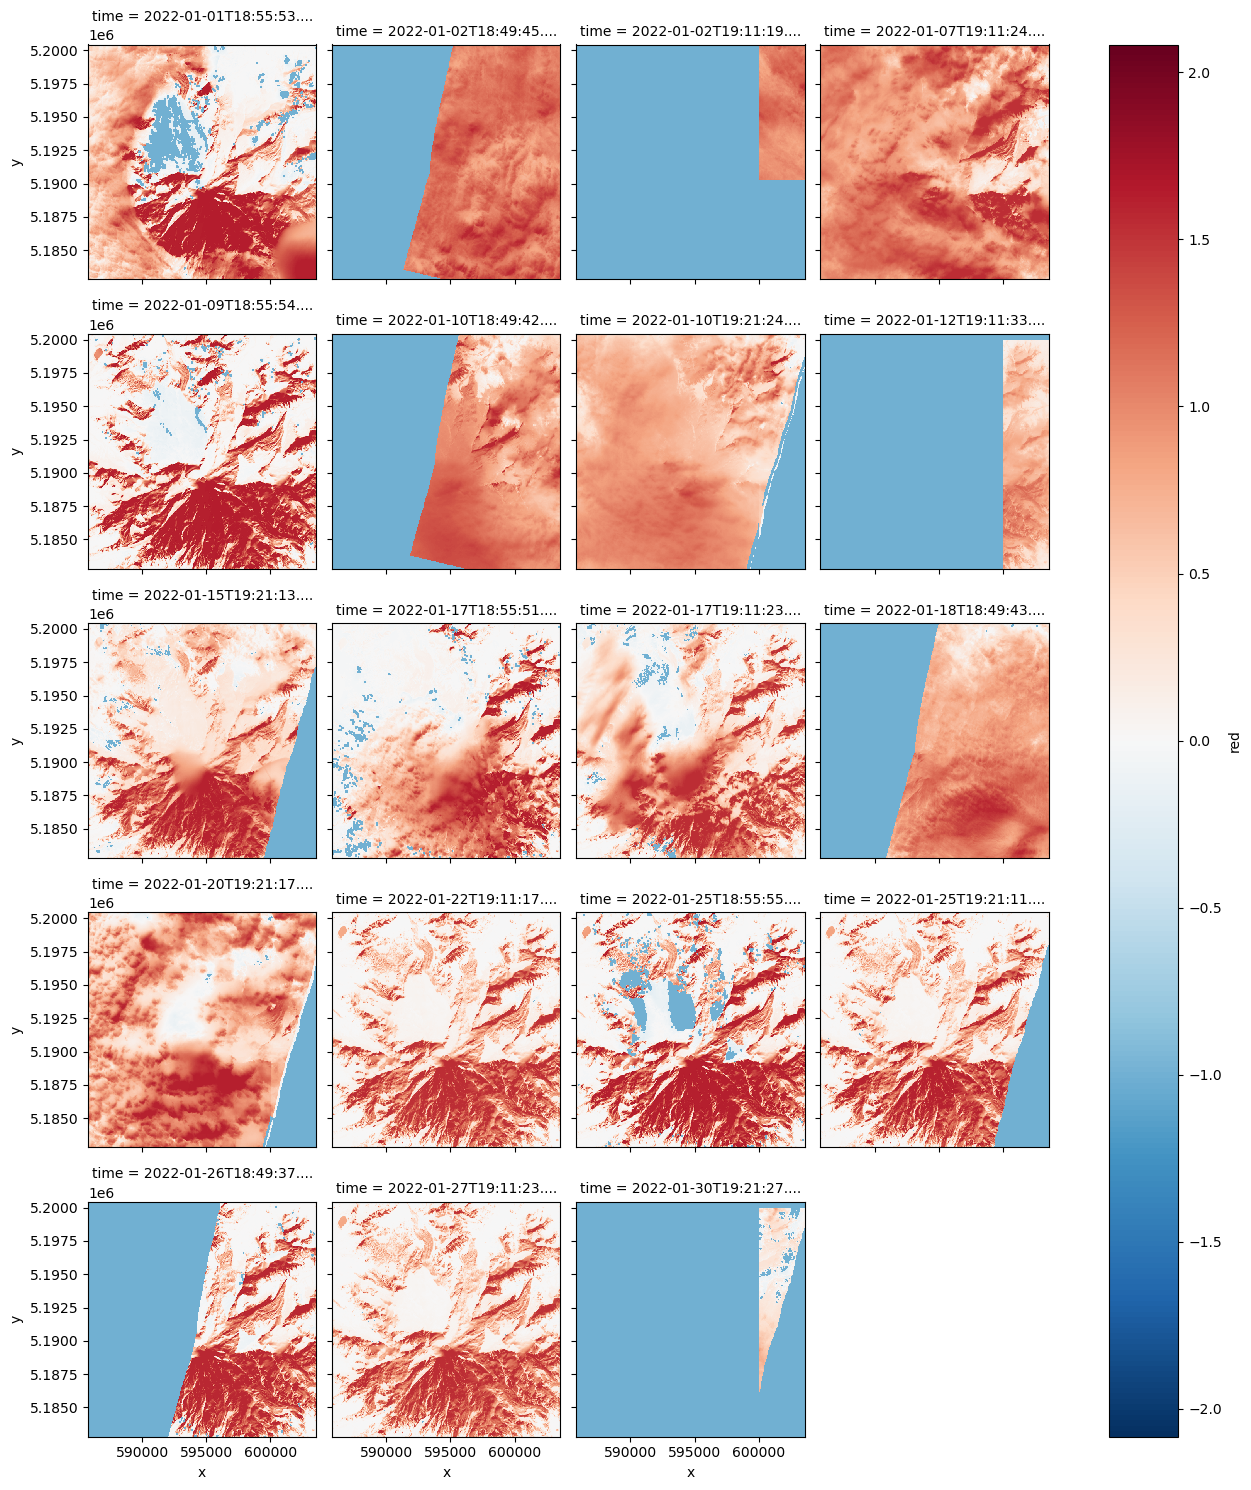

In [94]:
hls.data['red'].plot.imshow(col='time',col_wrap=4)

In [95]:
hls.data[['red','green','blue']].to_dataarray(dim='band').isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4,robust=True)

RasterioIOError: /vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TFS.2022018T185007.v2.0/HLS.L30.T10TFS.2022018T185007.v2.0.B02.tif: /vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TFS.2022018T185007.v2.0/HLS.L30.T10TFS.2022018T185007.v2.0.B02.tif:Cannot read TIFF header

In [ ]:
hls.metadata

In [ ]:
hls.metadata

In [ ]:
hls.metadata.datetime.diff().dt.total_seconds().gt(60).cumsum()

In [ ]:
HLS_metadata = gpd.GeoDataFrame.from_features(HLS_sentinel_stac_items.to_dict(transform_hrefs=True),'EPSG:4326')
HLS_metadata['datetime'] = pd.to_datetime(HLS_metadata['datetime']).sort_values()
HLS_metadata['group'] = HLS_metadata['datetime'].diff().dt.total_seconds().gt(500).cumsum()

#HLS_metadata.set_index('datetime').groupby(pd.Grouper(freq='D',dropna=True)).groups

In [ ]:
HLS_metadata.groupby('group').first()

In [ ]:
#S30_ds.coords['platform'] = #in metadata SPACECRAFT_NAME=Sentinel-2B

In [ ]:
testing = xr.concat((L30_ds,S30_ds), dim='time',fill_value=-9999).sortby("time")

In [ ]:
testing

In [ ]:
(testing['thermal'].isel(time=slice(0,12))).plot(col='time',col_wrap=4,robust=True)

In [ ]:
testing['Fmask'].isel(time=0).plot.imshow()

In [ ]:
plt.hist(0.0001*testing['red'].isel(time=0).values.ravel(),bins=200)

In [ ]:
testing['red'].where(testing['red']>=0).isel(time=0).plot.imshow()

In [ ]:
testing['green'].isel(time=0).plot.imshow()

In [ ]:
testing['blue'].isel(time=0).plot.imshow()

In [ ]:
testing[['red','green','blue']].to_dataarray(dim='band').isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4,robust=True)#.plot.imshow(col='time',col_wrap=4,robust=True)#(band='rgb')

In [ ]:
S30_ds['red'].isel(time=0).plot()

In [ ]:
L30_ds['red'].isel(time=0).plot()

In [ ]:
!pip install -q stackstac
import stackstac

In [ ]:
#https://hrodmn.dev/posts/hls/
#https://github.com/hrodmn/hls-tools/blob/main/hls_tools/__init__.py
#https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html
stackstac.stack(stac_items,bounds=bbox_gdf.total_bounds, assets=['red','green','blue'], epsg=32610,resolution=30)

In [ ]:
odc.stac.extract_collection_metadata(item)

In [ ]:
odc.stac.load(stac_items,bbox=bbox_gdf.total_bounds,chunks={},crs='utm',resolution=30, fail_on_error=False)

In [ ]:
#HLS https://lpdaac.usgs.gov/documents/842/HLS_Tutorial.html


#import folium
# try reduced res
# rgba_test = s2.data[['red','green','blue']].odc.to_rgba(vmin=0,vmax=15000)
# _map = folium.Map()
# rgba_test.isel(time=10).odc.add_to(_map,fmt='png')
# _map.fit_bounds(rgba_test.odc.map_bounds())
# s2.metadata.explore('s2:mgrs_tile',m=_map,style_kwds=dict(fillOpacity=0, width=0.3, opacity=0.3),popup=True)


#import hvplot.xarray
#!pip install hvplot
#!pip install jupyter_bokeh
#s2.rgb.hvplot.rgb('x', 'y', bands='band',  groupby='time', frame_width=600,robust=True)
